**Introduction:**

Heart disease is a common cause of death in the United States. For every 5 people, 1 will suffer from this condition. Due to the ever-prevalent nature of this disease, we believe it is important to know where one currently stands at the moment. With this project, we aim to predict and classify the severity of heart conditions based upon several variables. With the provided heart disease dataset, we are able to train a model based upon 297 rows of data. 

(Will rewrite a bit)


**Method and Results**

Before we start doing any kind of work with our data, we need to load our neccesary libraries. These libraries contain the neccesary packages that will allow us to process, mutate, and eventually for presenting our data.

In [119]:
library(dplyr)
library(tidyr) #Loading all libraries 
library(forcats)
library(purrr)
library(readr)
library(ggplot2)
library(cowplot)
library(repr)
library(tidyverse)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)


Due to the original dataset being packaged in a ".zip" file, we needed to extract the package locally first. For this project, we decided on the Cleveland dataset, as it best represents our capabilities and skills. Then, we uploaded our selected dataset onto Github, which would allow us to download the document onto this notebook. We used the URL containing the raw document for our purposes. In combination with the download.file command, we were able to load the dataset from the web


In [120]:
download.file("https://raw.githubusercontent.com/000557A/WebDataSet/main/processed.cleveland.data",
              "Data/unprocessed.cleveland.data")

As indicated by the UC Irvine Machine Learning Repository (Where this dataset originated from), we know that this dataset has some missing columns. In the table included on the website, we see that the "ca" and "thal" variables contain missing values. A quick glance at our dataset allowed us to see that the placeholder values were indicated with a "?".

Another aspect of this dataset is the missing column names. We retrieved the list of variables form the UC Irvine Repository, and added them back to our dataset.

We have also decided to mutate each variable as a factor. This would allow us to ... (NOT FINISHED)

In [121]:
heart_data <- read_delim("Data/processed.cleveland.data", delim = ",",
          col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak" , "slope", "ca", "thal", "num")
                        )|> filter(ca != '?' , thal != "?") |>
mutate("sex" = as.factor(sex),
       "cp" = as.factor(cp),
       "fbs" = as.factor(fbs),
       "restecg" = as.factor(restecg),
       "exang" = as.factor(exang),
      "num" = as.factor(num))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


At this step, we also noticed that our dataset was still saved as a ".data" file, rather than the commonly used ".csv". Through this discovery, we converted our processed dataset into a csv file.

In [122]:
write.csv(heart_data, "Data/data.csv")

When we finally opened our newly created file, we realized that the first column was not something we wanted to keep. It contained the numbers that each row corresponded to, thus it was removed through "select"

In [123]:
bob <- read_csv("Data/data.csv")|>
        select(age:num)

New names:
• `` -> `...1`
Rows: 297 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (15): ...1, age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


After our preliminary data processing, we were now ready to create summaries for our data. Many of the variables were irrelevent for our research, so we excluded them in our summarization tibble. As a group, we believed it was important to find the average age, resting blood pressure, serum colestoral levels, and maximum heart rate achieved. Aside from these variables, we also wanted to know how much data we had, thus we included the total observation count. 

In [124]:
heart_data_mean <-bob |>
map_df(mean)|>
mutate("Observation Count" = nrow(bob)) |>
select(age,trestbps,chol,thalach,num,"Observation Count")

#The actual table
heart_data_mean


age,trestbps,chol,thalach,num,Observation Count
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
54.54209,131.6936,247.3502,149.5993,0.9461279,297


Before we start doing any kind classification, we need to split the data into 2 segments, a training set and a testing set.


In [125]:
set.seed(727)
heart_split <- initial_split(heart_data, prop = 0.75, strata = num)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

After we split the data, we MUST scale and center our data. This is because K-Nearest Neighbor classification relies heavily on the scale of the predictors.

Since we are predicting the severity of the heart disagnostic based on age, resting heartbeat, etc. , we need to include these things in our recipe too.

In [126]:
set.seed(727)
heart_recipe <- recipe(num ~ age  + thalach + chol + trestbps , data = heart_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Since we don't exactly know what number of neighors to use yet, lets just test a range between 2 neighors and 6.

In [127]:
kvalues <- tibble(neighbors = seq(from = 2, to = 8, by = 1))

In order to ensure that our data is easily reproducible, we need to set a seed.

For this project, we decided on setting the seed as 727.

Since we are using KNN classification, it is important to find the best number of neighbors for classification.
In order to do this, we will use 5-fold-cross-validation.

The following code will be used to determine the optimal number of neighors used for this approximation


In [128]:
set.seed(727)

heart_vfold <- vfold_cv (heart_train, v = 5, strata = 4)

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode ("classification")

heart_wkfl <- workflow ()|>
            add_model(knn_tune)|>
            add_recipe(heart_recipe)|>
            tune_grid(resamples = heart_vfold, grid = kvalues)|>
            collect_metrics()



In order to see the accuracy each K value gives, we need to filter our workflow to only contain the accuracy.

In [129]:
accuracy_data <- heart_wkfl |>
            filter(.metric == "accuracy")


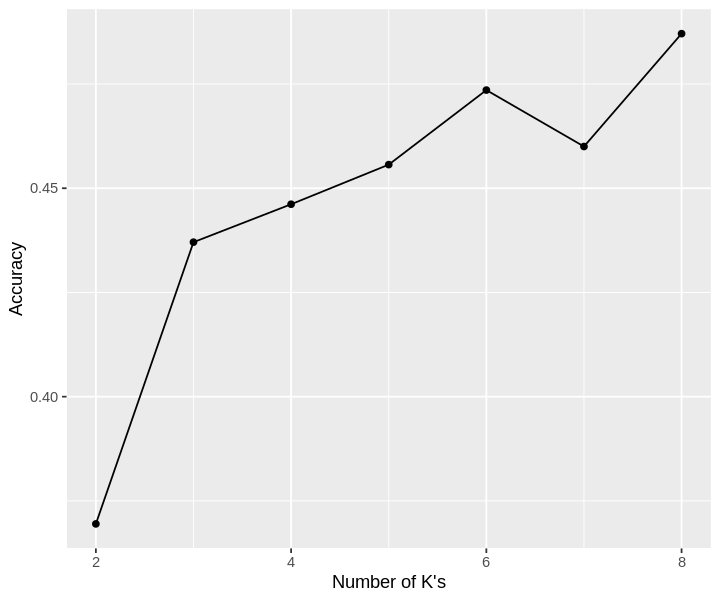

In [130]:
options(repr.plot.height = 5, repr.plot.width = 6)
# This top part is to make the graph fit the screen better

cross_val_plot <- accuracy_data |>
    ggplot(aes (x = neighbors, y = mean))+
    geom_point()+
    geom_line(aes(x = neighbors, y = mean))+
    xlab("Number of K's")+
    ylab ("Accuracy")

cross_val_plot

Looking at this graph, we see that the best number of neighbors is 6.

Therefore, we will proceed with this project using 6 neighbors for classification.


In [131]:
set.seed(727)


knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |>
       set_engine("kknn") |>
       set_mode("classification")

heart_fit <- workflow() |>
       add_recipe(heart_recipe) |>
       add_model(knn_spec) |>
       fit(data = heart_train)






Now we can predict! We will use the predict function to generate predictions for all of the observations in our test set using the model we trained from our training set.

In [132]:
set.seed(727)
heart_test_predictions <- predict(heart_fit , heart_test) |>
       bind_cols(heart_test)


heart_test_predictions

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<fct>
0,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
0,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
0,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,56,1,2,130,221,0,2,163,0,0.0,1,0.0,7.0,0
4,63,1,4,140,187,0,2,144,1,4.0,1,2.0,7.0,2
4,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2


To quantify whether or not this model can successfuly predict the severity of heart disease, we will use the metrics function. Understanding the quality of our model with the upcoming functions will help us answer our question of whether this dataset can be used to predict heart disease severity. 

In [133]:
set.seed(727)
heart_prediction_accuracy <- heart_test_predictions |>
         metrics(truth = num, estimate = .pred_class)             

heart_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4800000
kap,multiclass,0.1005535
